In [2]:
import os
from gpuutils import GpuUtils
GpuUtils.allocate(gpu_count=1, framework='keras')

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True) 

import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
np.set_printoptions(precision=3, suppress=True)
from sklearn.preprocessing import MinMaxScaler


GPU 0  will be allocated


In [3]:
df = pd.read_csv('/mnt/md0/aholmberg/data/raytrace_samples_angle.csv')

#df['launch_angle'] = np.arctan2(df['launch_vec_r'].to_numpy(), df['launch_vec_z'].to_numpy())
#df['recieve_angle'] = np.arctan2(df['recieve_vec_r'].to_numpy(), df['recieve_vec_z'].to_numpy())
#df.to_csv('/mnt/md0/aholmberg/data/raytrace_samples_angle.csv', index=False)
df.head()

,type,source_pos_r,source_pos_z,antenna_pos_z,travel_time,path_length,launch_vec_r,launch_vec_z,recieve_vec_r,recieve_vec_z,launch_angle,recieve_angle
0,1,-261.242691,-1519.202542,-100.751798,8533.739837,1442.308966,0.180477,0.983579,-0.192862,-0.981226,0.181471,-2.947514
1,3,-261.242691,-1519.202542,-100.751798,9551.954357,1640.948938,0.155664,0.987810,-0.166347,0.986067,0.156300,-0.167123
2,1,-844.747055,-1323.075186,-55.432448,8980.283362,1523.474031,0.550266,0.834990,-0.622250,-0.782819,0.582682,-2.469980
3,3,-844.747055,-1323.075186,-55.432448,9401.088379,1617.929840,0.509373,0.860546,-0.576008,0.817444,0.534456,-0.613836
4,1,-1726.403817,-2055.720259,-193.666015,15064.523751,2539.241494,0.679340,0.733824,-0.692648,-0.721276,0.746863,-2.376439


In [4]:
sc_pos_r = df['source_pos_r'].to_numpy().astype(np.float32)
sc_pos_z = df['source_pos_z'].to_numpy().astype(np.float32)
ant_pos_z = df['antenna_pos_z'].to_numpy().astype(np.float32)
features = np.stack((sc_pos_r, sc_pos_z, ant_pos_z), axis=1)

path_length = df['path_length'].to_numpy().astype(np.float32)
travel_time = df['travel_time'].to_numpy().astype(np.float32)

#launch_vec_r = df['launch_vec_r'].to_numpy().astype(np.float32)
#launch_vec_z = df['launch_vec_z'].to_numpy().astype(np.float32)
#launch = np.stack((launch_vec_r, launch_vec_z), axis=1)

#recieve_vec_r = df['recieve_vec_r'].to_numpy().astype(np.float32)
#recieve_vec_z = df['recieve_vec_z'].to_numpy().astype(np.float32)
#recieve = np.stack((recieve_vec_r, recieve_vec_z), axis=1)

launch = df['launch_angle'].to_numpy().astype(np.float32)
recieve = df['recieve_angle'].to_numpy().astype(np.float32)

typ = df['type'].to_numpy()
print(launch.shape, recieve.shape, travel_time.shape, path_length.shape)

(453758,) (453758,) (453758,) (453758,)


In [5]:
features  = features[0::2,:]
features_train = features[:int(features.shape[0]*0.8)]
features_test = features[int(features.shape[0]*0.8):]

temp1 = travel_time[0::2]
temp2 = travel_time[1::2]
out_time = np.stack((temp1, temp2), axis=1)
out_time_train = out_time[:int(out_time.shape[0]*0.8),:]
out_time_test = out_time[int(out_time.shape[0]*0.8):,:]


temp1 = path_length[0::2]
temp2 = path_length[1::2]
out_length = np.stack((temp1, temp2), axis=1)
out_length_train = out_length[:int(out_length.shape[0]*0.8),:]
out_length_test = out_length[int(out_length.shape[0]*0.8):,:]

temp1 = launch[0::2]
temp2 = launch[1::2]
out_launch = np.stack((temp1, temp2), axis=1)
out_launch_train = out_launch[:int(out_launch.shape[0]*0.8),:]
out_launch_test = out_launch[int(out_launch.shape[0]*0.8):,:]

temp1 = recieve[0::2]
temp2 = recieve[1::2]
out_recieve = np.stack((temp1, temp2), axis=1)
out_recieve_train = out_recieve[:int(out_recieve.shape[0]*0.8),:]
out_recieve_test = out_recieve[int(out_recieve.shape[0]*0.8):,:]

"""
out1_train = out1[:int(out1.shape[0]*0.8)]
out1_test = out1[int(out1.shape[0]*0.8):]

out2_train = out2[:int(out2.shape[0]*0.8)]
out2_test = out2[int(out2.shape[0]*0.8):]
"""
print(out_time.shape, out_length.shape, out_launch.shape, out_recieve.shape)

(226879, 2) (226879, 2) (226879, 2) (226879, 2)


In [6]:
temp1 = typ[0::2]
temp2 = typ[1::2]
print(temp1, temp2, typ)
print(temp1.shape, temp2.shape, typ.shape)
unique, counts = np.unique(temp1, return_counts=True)
a = dict(zip(unique, counts))
unique, counts = np.unique(temp2, return_counts=True)
b = dict(zip(unique, counts))
print(a, b)

[1 1 1 ... 1 1 1] [3 3 3 ... 3 3 3] [1 3 1 ... 3 1 3]
(226879,) (226879,) (453758,)
{1: 222350, 2: 4529} {2: 19933, 3: 206946}


In [7]:
unique, counts = np.unique(features_train[:,0], return_counts=True)
#c = dict(zip(unique, counts))
print(max(counts))

2


In [8]:
scaler_features = MinMaxScaler(feature_range=(0,1))
scaler_features.fit(features_train)
norm_features_train = scaler_features.transform(features_train)
norm_features_test = scaler_features.transform(features_test)

scaler_time = MinMaxScaler(feature_range=(0,1))
scaler_time.fit(out_time_train)
norm_time_train = scaler_time.transform(out_time_train)
norm_time_test = scaler_time.transform(out_time_test)

scaler_length = MinMaxScaler(feature_range=(0,1))
scaler_length.fit(out_length_train)
norm_length_train = scaler_length.transform(out_length_train)
norm_length_test = scaler_length.transform(out_length_test)

scaler_launch = MinMaxScaler(feature_range=(0,1))
scaler_launch.fit(out_launch_train)
norm_launch_train = scaler_launch.transform(out_launch_train)
norm_launch_test = scaler_launch.transform(out_launch_test)

scaler_recieve = MinMaxScaler(feature_range=(0,1))
scaler_recieve.fit(out_recieve_train)
norm_recieve_train = scaler_recieve.transform(out_recieve_train)
norm_recieve_test = scaler_recieve.transform(out_recieve_test)

#normalize = layers.Normalization()
#normalize.adapt(features_train)

In [9]:
"""
inputs = keras.Input(shape=(3, ))
#x = normalize(inputs)
x = layers.Dense(32, activation='relu')(inputs)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x1 = layers.Dense(64, activation='relu')(x)
x2 = layers.Dense(64, activation='relu')(x)
x3 = layers.Dense(64, activation='relu')(x)
x4 = layers.Dense(64, activation='relu')(x)
x1 = layers.Dense(32, activation='relu')(x1)
x2 = layers.Dense(32, activation='relu')(x2)
x3 = layers.Dense(32, activation='relu')(x3)
x4 = layers.Dense(32, activation='relu')(x4)
output_time = layers.Dense(2, activation='relu')(x1)
output_length = layers.Dense(2, activation='relu')(x2)
output_launch = layers.Dense(4, activation='relu')(x3)
output_recieve = layers.Dense(4, activation='relu')(x4)
"""


"\ninputs = keras.Input(shape=(3, ))\n#x = normalize(inputs)\nx = layers.Dense(32, activation='relu')(inputs)\nx = layers.Dense(64, activation='relu')(x)\nx = layers.Dense(128, activation='relu')(x)\nx1 = layers.Dense(64, activation='relu')(x)\nx2 = layers.Dense(64, activation='relu')(x)\nx3 = layers.Dense(64, activation='relu')(x)\nx4 = layers.Dense(64, activation='relu')(x)\nx1 = layers.Dense(32, activation='relu')(x1)\nx2 = layers.Dense(32, activation='relu')(x2)\nx3 = layers.Dense(32, activation='relu')(x3)\nx4 = layers.Dense(32, activation='relu')(x4)\noutput_time = layers.Dense(2, activation='relu')(x1)\noutput_length = layers.Dense(2, activation='relu')(x2)\noutput_launch = layers.Dense(4, activation='relu')(x3)\noutput_recieve = layers.Dense(4, activation='relu')(x4)\n"

In [10]:
#model = keras.Model(inputs=inputs, outputs=[output_time, output_length, output_launch, output_recieve], name="full_model")
from raytrace_model_def import Fc_model
activation = keras.layers.ReLU()
layers = [128, 256, 512]
model = Fc_model(layers, activation)

In [11]:
#keras.utils.plot_model(model, "travel_time_model.png")

In [12]:
model.build((1,3))
print(model.summary())

Model: "fc_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              multiple                  1408      
_________________________________________________________________
dense_2 (Dense)              multiple                  33024     
_________________________________________________________________
dense_3 (Dense)              multiple                  131584    
_________________________________________________________________
dense (Dense)                multiple                  40        
_________________________________________________________________
dense_4 (Dense)              multiple                  4104      
Total params: 170,160
Trainable params: 170,160
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
model.compile(optimizer='adam', loss='mse')

In [14]:
y = np.concatenate((norm_time_train, norm_length_train, norm_launch_train, norm_recieve_train), axis=1)
print(norm_features_train.shape)

(181503, 3)


In [15]:
#model.fit(norm_features_train, [norm_time_train, norm_length_train, norm_launch_train, norm_recieve_train], epochs=5)
model.fit(norm_features_train, y, epochs=1)

5672/5672 [==============================] - 18s 3ms/step - loss: 0.0032


In [16]:
"""
y_test = model(norm_features_test)
y_time = y_test[0].numpy()
y_length = y_test[1].numpy()
y_launch = y_test[2].numpy()
y_recieve = y_test[3].numpy()
"""
y_test = model(norm_features_test).numpy()
print(y_test.shape)
y_time = y_test[:,:2]
y_length = y_test[:,2:4]
y_launch = y_test[:,4:6]
y_recieve = y_test[:,6:8]


(45376, 8)


In [17]:
import matplotlib.pyplot as plt
print(y_time.shape, norm_time_test.shape)

(45376, 2) (45376, 2)


Text(0, 0.5, 'Network prediction (ns)')

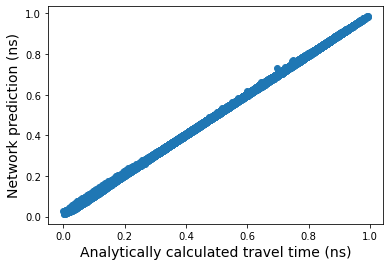

In [18]:
plt.scatter(norm_time_test[:,0], y_time[:,0])
plt.xlabel('Analytically calculated travel time (ns)', size=14)
plt.ylabel('Network prediction (ns)', size=14)
#plt.savefig('model_pred_1.svg')

Text(0, 0.5, 'Network prediction (ns)')

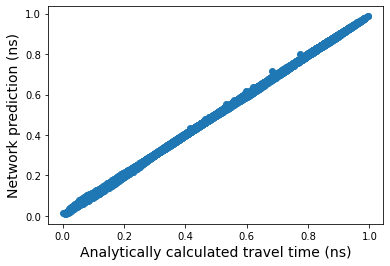

In [19]:
plt.scatter(norm_time_test[:,1], y_time[:,1])
plt.xlabel('Analytically calculated travel time (ns)', size=14)
plt.ylabel('Network prediction (ns)', size=14)
#plt.savefig('model_pred_2.svg')

In [20]:
y_time_inv = scaler_time.inverse_transform(y_time)
diff_time = out_time_test - y_time_inv
print(f'Mean of difference true-pred {np.mean(diff_time[:,0]):.4f} Std {np.std(diff_time[:,0]):.4f}')
print(f'Mean of difference true-pred {np.mean(diff_time[:,1]):.4f} Std {np.std(diff_time[:,1]):.4f}')

Mean of difference true-pred -48.0171 Std 81.3692
Mean of difference true-pred -10.7276 Std 72.8668


In [21]:
y_length_inv = scaler_length.inverse_transform(y_length)
diff_length = out_length_test - y_length_inv
print(f'Mean of difference true-pred {np.mean(diff_length[:,0]):.4f} Std {np.std(diff_length[:,0]):.4f}')
print(f'Mean of difference true-pred {np.mean(diff_length[:,1]):.4f} Std {np.std(diff_length[:,1]):.4f}')

Mean of difference true-pred 6.6258 Std 15.0692
Mean of difference true-pred -2.8749 Std 14.5014


In [22]:
y_launch_inv = scaler_launch.inverse_transform(y_launch)
diff_launch = out_launch_test - y_launch_inv
print(f'Mean of difference true-pred {np.mean(diff_launch[:,0]):.4f} Std {np.std(diff_launch[:,0]):.4f}')
print(f'Mean of difference true-pred {np.mean(diff_launch[:,1]):.4f} Std {np.std(diff_launch[:,1]):.4f}')

Mean of difference true-pred 0.0003 Std 0.0406
Mean of difference true-pred 0.0062 Std 0.0208


In [23]:
y_recieve_inv = scaler_recieve.inverse_transform(y_recieve)
diff_recieve = out_recieve_test - y_recieve_inv
print(f'Mean of difference true-pred {np.mean(diff_recieve[:,0]):.4f} Std {np.std(diff_recieve[:,0]):.4f}')
print(f'Mean of difference true-pred {np.mean(diff_recieve[:,1]):.4f} Std {np.std(diff_recieve[:,1]):.4f}')

Mean of difference true-pred 0.0026 Std 0.0434
Mean of difference true-pred 0.0017 Std 0.0270


In [24]:
#print(y_length_inv)

In [25]:
from radiotools import plthelpers as php
fix, ax = php.get_histogram(diff_length[:,1], bins=50)
plt.show()
#print(norm_time_train)

ModuleNotFoundError: No module named 'past'